In [399]:
from ott.solvers import linear
from ott.geometry import pointcloud
import jax.numpy as jnp
import jax
from jaxtyping import Array, Float
from ott.solvers.linear.implicit_differentiation import ImplicitDiff
import matplotlib.pyplot as plt
import optax
import functools

<BarContainer object of 201 artists>

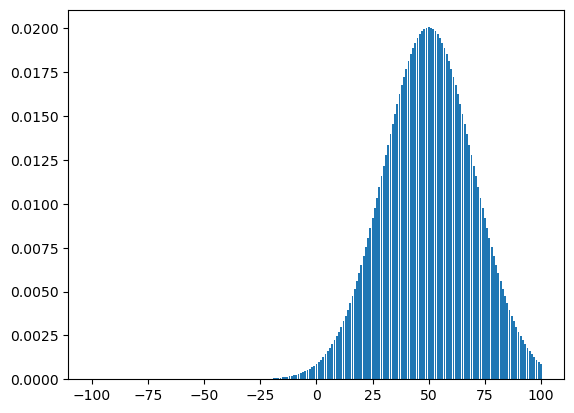

In [472]:
# initialize a gaussian kernel, mu_true, on domain X
size = 100
sigma = 20
X = jnp.arange(-size, size + 1, 1).astype(float)
mu_true = jnp.exp(-((X-50)**2) / (2 * sigma**2)) # gaussian kernel (sigma = 1, center = 0)
mu_true /= jnp.sum(mu_true)
plt.bar(X, mu_true)

In [479]:
solve_fn = jax.jit(linear.solve)

"""
Compute regularized ot cost for transporting between marginals mu and mu_true on geometry x
"""
def ot_marginal_loss(mu: Float[Array, "n "], mu_true: Float[Array, "n "], x: Float[Array, "n d"]):
    geom = pointcloud.PointCloud(x, x)
    ot = solve_fn(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true)
    return ot.reg_ot_cost

"""
Compute W2 distance between marginals mu and mu_true on geometry x
"""
def ot_marginal_loss_w2(mu: Float[Array, "n "], mu_true: Float[Array, "n "], x: Float[Array, "n d"]):
    geom = pointcloud.PointCloud(x, x)
    ot = solve_fn(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true)
    return jnp.dot(ot.geom.cost_matrix.ravel(), ot.matrix.ravel())

"""
ot primal cost for transporting between marginals mu and mu_true on geometry x
"""
def ot_marginal_loss_primal(mu: Float[Array, "n "], mu_true: Float[Array, "n "], x: Float[Array, "n d"]):
    geom = pointcloud.PointCloud(x, x)
    ot = solve_fn(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true)
    return ot.primal_cost

"""
1-d gaussian kernel with center c, standard deviation sigma, domain
"""
def gaussian_kernel(c, sigma, X):
    mu = jnp.exp(-((X-c)**2)/(2 * sigma**2))
    mu /= jnp.sum(mu)
    return mu

"""
learning the center of a gaussian marginal - doesn't work
"""
def loss(c: Array, mu_true: Float[Array, "n "], sigma: Float=5.0, X: Float[Array, "n "] = X):
    # chatgpt-generated code
    log_mu = -((X - c) ** 2) / (2 * sigma ** 2)  # Log-space Gaussian kernel
    mu = jnp.exp(log_mu - jnp.logsumexp(log_mu))  # More numerically stable normalization
    
    return jnp.mean(mu)
    #return ot_marginal_loss(mu, mu_true, X.reshape(X.shape[0], 1).astype(float)) # return cost to transport to mu_true

"""
loss function for logits of a probability distribution
"""
def logit_loss(theta: Float[Array, "n"], mu_true: Float[Array, "n "], X: Float[Array, "n 1 "] = X):
    mu = jax.nn.softmax(theta)
    return ot_marginal_loss(mu, mu_true, X)

In [486]:
"""
l2 distance between logits and probability distribution
"""
def logit_l2_loss(theta: Float[Array, "n "], marginal: Float[Array, "n "]):
    mu = jax.nn.softmax(theta)
    return jnp.sqrt(jnp.sum((mu - marginal)**2))

"""
learn the logits of a probability distribution
"""
def learn_marginal_logits(marginal: Float[Array, "n "], X: Float[Array, "n "], marginal_comparison_fn, seed=42, training_steps=500):
    solver = optax.adam(learning_rate=0.03)
    key = jax.random.PRNGKey(42)
    key, subkey = jax.random.split(key)
    
    theta_init = jax.random.normal(key=subkey, shape=X.shape[0])
    theta = theta_init
    opt_state = solver.init(theta)
    
    X_reshaped = X.reshape((X.shape[0], 1)).astype(float)
    
    # create loss function
    def loss_fn(theta: Float[Array, "n"], mu_true: Float[Array, "n "], X: Float[Array, "n 1 "] = X):
        mu = jax.nn.softmax(theta)
        return marginal_comparison_fn(mu, mu_true, X)
    
    loss_fn = functools.partial(loss_fn, mu_true=marginal, X=X_reshaped)
    
    @jax.jit
    def make_step(theta, opt_state):
        loss_val, grads = jax.value_and_grad(loss_fn)(theta)
        updates, opt_state = solver.update(grads, opt_state)
        theta = optax.apply_updates(theta, updates)
        return loss_val, theta, opt_state
    
    for i in range(training_steps):
        loss_val, theta, opt_state = make_step(theta, opt_state) # gradient update based on W2 distance
        l2_loss_val = logit_l2_loss(theta, marginal)
        print(f"iteration {i}, loss value {loss_val}, l2 loss: {l2_loss_val}")
    
    return theta, (theta_init,)

iteration 0, loss value 4650.78466796875, l2 loss: 0.12481006234884262
iteration 1, loss value 4483.77490234375, l2 loss: 0.12406411021947861
iteration 2, loss value 4320.23095703125, l2 loss: 0.12338995188474655
iteration 3, loss value 4160.2734375, l2 loss: 0.12278896570205688
iteration 4, loss value 4004.1494140625, l2 loss: 0.12226098030805588
iteration 5, loss value 3852.0, l2 loss: 0.12180448323488235
iteration 6, loss value 3704.01220703125, l2 loss: 0.12141726911067963
iteration 7, loss value 3560.33447265625, l2 loss: 0.1210964024066925
iteration 8, loss value 3419.380859375, l2 loss: 0.1208382174372673
iteration 9, loss value 3284.739501953125, l2 loss: 0.12063856422901154
iteration 10, loss value 3154.6513671875, l2 loss: 0.12049291282892227
iteration 11, loss value 3029.12646484375, l2 loss: 0.12039678543806076
iteration 12, loss value 2908.178466796875, l2 loss: 0.12034586817026138
iteration 13, loss value 2791.765380859375, l2 loss: 0.12033617496490479
iteration 14, loss 

iteration 124, loss value 323.4700622558594, l2 loss: 0.1230984479188919
iteration 125, loss value 321.26873779296875, l2 loss: 0.12287236005067825
iteration 126, loss value 319.1054992675781, l2 loss: 0.12264527380466461
iteration 127, loss value 316.97906494140625, l2 loss: 0.12241736054420471
iteration 128, loss value 314.886962890625, l2 loss: 0.12218871712684631
iteration 129, loss value 312.83154296875, l2 loss: 0.12195948511362076
iteration 130, loss value 310.80889892578125, l2 loss: 0.121729776263237
iteration 131, loss value 308.8200988769531, l2 loss: 0.12149970233440399
iteration 132, loss value 306.8670654296875, l2 loss: 0.12126940488815308
iteration 133, loss value 304.9433288574219, l2 loss: 0.12103898823261261
iteration 134, loss value 303.0535583496094, l2 loss: 0.12080857157707214
iteration 135, loss value 301.1927795410156, l2 loss: 0.12057828158140182
iteration 136, loss value 299.36419677734375, l2 loss: 0.1203482523560524
iteration 137, loss value 297.56631469726

iteration 244, loss value 209.38681030273438, l2 loss: 0.10752138495445251
iteration 245, loss value 209.11038208007812, l2 loss: 0.10749714821577072
iteration 246, loss value 208.83914184570312, l2 loss: 0.10747338086366653
iteration 247, loss value 208.57260131835938, l2 loss: 0.10745009779930115
iteration 248, loss value 208.31065368652344, l2 loss: 0.10742727667093277
iteration 249, loss value 208.052978515625, l2 loss: 0.10740483552217484
iteration 250, loss value 207.80007934570312, l2 loss: 0.10738280415534973
iteration 251, loss value 207.5509490966797, l2 loss: 0.10736113786697388
iteration 252, loss value 207.30636596679688, l2 loss: 0.10733982920646667
iteration 253, loss value 207.06539916992188, l2 loss: 0.10731881856918335
iteration 254, loss value 206.82838439941406, l2 loss: 0.1072981059551239
iteration 255, loss value 206.596435546875, l2 loss: 0.10727766901254654
iteration 256, loss value 206.36776733398438, l2 loss: 0.10725749284029007
iteration 257, loss value 206.1

iteration 359, loss value 193.9197998046875, l2 loss: 0.10522212833166122
iteration 360, loss value 193.85256958007812, l2 loss: 0.10520095378160477
iteration 361, loss value 193.7862548828125, l2 loss: 0.1051797941327095
iteration 362, loss value 193.72052001953125, l2 loss: 0.10515865683555603
iteration 363, loss value 193.65435791015625, l2 loss: 0.10513756424188614
iteration 364, loss value 193.58920288085938, l2 loss: 0.10511648654937744
iteration 365, loss value 193.5238037109375, l2 loss: 0.10509543120861053
iteration 366, loss value 193.45889282226562, l2 loss: 0.10507441312074661
iteration 367, loss value 193.3953399658203, l2 loss: 0.10505342483520508
iteration 368, loss value 193.3314971923828, l2 loss: 0.10503248125314713
iteration 369, loss value 193.2682342529297, l2 loss: 0.10501156747341156
iteration 370, loss value 193.20443725585938, l2 loss: 0.10499067604541779
iteration 371, loss value 193.14234924316406, l2 loss: 0.10496985167264938
iteration 372, loss value 193.08

iteration 478, loss value 187.87826538085938, l2 loss: 0.10305352509021759
iteration 479, loss value 187.83889770507812, l2 loss: 0.10303883999586105
iteration 480, loss value 187.79971313476562, l2 loss: 0.1030241921544075
iteration 481, loss value 187.76063537597656, l2 loss: 0.10300964117050171
iteration 482, loss value 187.72186279296875, l2 loss: 0.10299511253833771
iteration 483, loss value 187.68312072753906, l2 loss: 0.10298065841197968
iteration 484, loss value 187.64483642578125, l2 loss: 0.10296625643968582
iteration 485, loss value 187.6063995361328, l2 loss: 0.10295191407203674
iteration 486, loss value 187.56793212890625, l2 loss: 0.10293763130903244
iteration 487, loss value 187.52989196777344, l2 loss: 0.10292340815067291
iteration 488, loss value 187.49160766601562, l2 loss: 0.10290922224521637
iteration 489, loss value 187.4536895751953, l2 loss: 0.10289511829614639
iteration 490, loss value 187.41624450683594, l2 loss: 0.1028810515999794
iteration 491, loss value 187

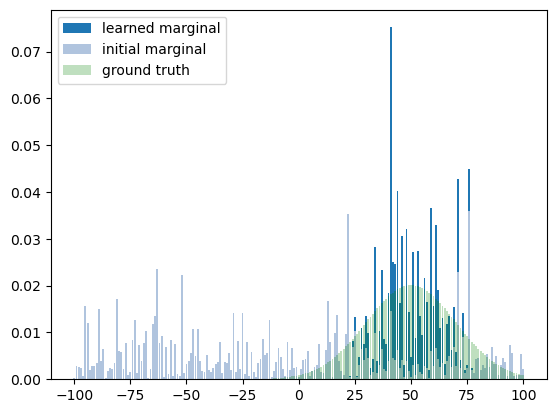

In [489]:
# plot learned distribution using w2 dist for ot comparison
learned, theta_init = learn_marginal_logits(mu_true, X, ot_marginal_loss_w2)
learned_mu_true = jax.nn.softmax(learned)
mu_init = jax.nn.softmax(theta_init[0])
plt.bar(X, learned_mu_true, label="learned marginal")
plt.bar(X, mu_init, label="initial marginal", color="lightsteelblue")
plt.bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
plt.legend()
plt.show()

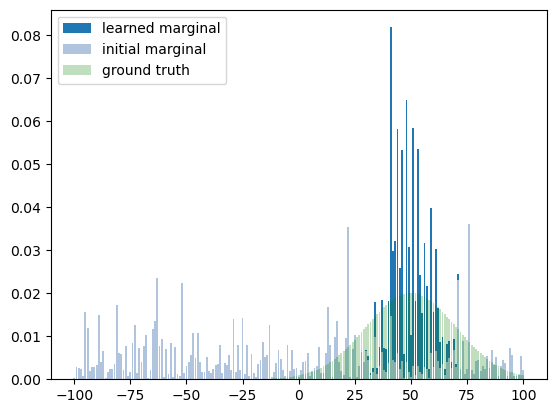

In [477]:
# plot learned distribution using ot.reg_ot_cost for ot comparison
learned, theta_init = learn_marginal_logits(mu_true, X, ot_marginal_loss)
learned_mu_true = jax.nn.softmax(learned)
mu_init = jax.nn.softmax(theta_init[0])
plt.bar(X, learned_mu_true, label="learned marginal")
plt.bar(X, mu_init, label="initial marginal", color="lightsteelblue")
plt.bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
plt.legend()
plt.show()

iteration 0, loss value 4650.86181640625, l2 loss: 0.12481006234884262
iteration 1, loss value 4483.876953125, l2 loss: 0.12406411021947861
iteration 2, loss value 4320.31103515625, l2 loss: 0.12338995188474655
iteration 3, loss value 4160.35107421875, l2 loss: 0.12278896570205688
iteration 4, loss value 4004.204833984375, l2 loss: 0.12226098775863647
iteration 5, loss value 3852.05615234375, l2 loss: 0.12180448323488235
iteration 6, loss value 3704.067138671875, l2 loss: 0.12141726911067963
iteration 7, loss value 3560.379638671875, l2 loss: 0.1210964024066925
iteration 8, loss value 3419.44091796875, l2 loss: 0.1208382248878479
iteration 9, loss value 3284.794921875, l2 loss: 0.12063856422901154
iteration 10, loss value 3154.705078125, l2 loss: 0.12049291282892227
iteration 11, loss value 3029.18212890625, l2 loss: 0.12039678543806076
iteration 12, loss value 2908.22607421875, l2 loss: 0.12034587562084198
iteration 13, loss value 2791.8115234375, l2 loss: 0.12033618241548538
iteratio

iteration 123, loss value 325.7107238769531, l2 loss: 0.1233234629034996
iteration 124, loss value 323.4732360839844, l2 loss: 0.1230984777212143
iteration 125, loss value 321.2709045410156, l2 loss: 0.12287236005067825
iteration 126, loss value 319.1080017089844, l2 loss: 0.1226452887058258
iteration 127, loss value 316.981201171875, l2 loss: 0.1224173754453659
iteration 128, loss value 314.89056396484375, l2 loss: 0.1221887394785881
iteration 129, loss value 312.8337097167969, l2 loss: 0.12195949256420135
iteration 130, loss value 310.8109436035156, l2 loss: 0.1217297911643982
iteration 131, loss value 308.82403564453125, l2 loss: 0.12149970233440399
iteration 132, loss value 306.8692626953125, l2 loss: 0.12126939743757248
iteration 133, loss value 304.9458312988281, l2 loss: 0.12103898078203201
iteration 134, loss value 303.0544738769531, l2 loss: 0.12080858647823334
iteration 135, loss value 301.1954040527344, l2 loss: 0.12057828903198242
iteration 136, loss value 299.3653869628906

iteration 243, loss value 209.66848754882812, l2 loss: 0.1075458750128746
iteration 244, loss value 209.38790893554688, l2 loss: 0.10752110928297043
iteration 245, loss value 209.1117401123047, l2 loss: 0.10749687254428864
iteration 246, loss value 208.84109497070312, l2 loss: 0.10747309029102325
iteration 247, loss value 208.57362365722656, l2 loss: 0.10744982212781906
iteration 248, loss value 208.31300354003906, l2 loss: 0.10742699354887009
iteration 249, loss value 208.05287170410156, l2 loss: 0.10740454494953156
iteration 250, loss value 207.80062866210938, l2 loss: 0.10738249868154526
iteration 251, loss value 207.55140686035156, l2 loss: 0.10736083984375
iteration 252, loss value 207.30735778808594, l2 loss: 0.1073395162820816
iteration 253, loss value 207.0670166015625, l2 loss: 0.10731850564479828
iteration 254, loss value 206.83047485351562, l2 loss: 0.10729778558015823
iteration 255, loss value 206.5984344482422, l2 loss: 0.10727736353874207
iteration 256, loss value 206.368

iteration 354, loss value 194.2639617919922, l2 loss: 0.10532788187265396
iteration 355, loss value 194.1941375732422, l2 loss: 0.10530658811330795
iteration 356, loss value 194.1246795654297, l2 loss: 0.10528533160686493
iteration 357, loss value 194.0572967529297, l2 loss: 0.1052640751004219
iteration 358, loss value 193.9886016845703, l2 loss: 0.10524284094572067
iteration 359, loss value 193.92071533203125, l2 loss: 0.10522162914276123
iteration 360, loss value 193.85462951660156, l2 loss: 0.10520045459270477
iteration 361, loss value 193.7882080078125, l2 loss: 0.10517928004264832
iteration 362, loss value 193.71957397460938, l2 loss: 0.10515815764665604
iteration 363, loss value 193.65481567382812, l2 loss: 0.10513705015182495
iteration 364, loss value 193.59056091308594, l2 loss: 0.10511598736047745
iteration 365, loss value 193.5246124267578, l2 loss: 0.10509492456912994
iteration 366, loss value 193.4604034423828, l2 loss: 0.10507390648126602
iteration 367, loss value 193.3966

iteration 471, loss value 188.1583709716797, l2 loss: 0.10315755009651184
iteration 472, loss value 188.11781311035156, l2 loss: 0.10314243286848068
iteration 473, loss value 188.0790557861328, l2 loss: 0.1031273826956749
iteration 474, loss value 188.0382080078125, l2 loss: 0.10311238467693329
iteration 475, loss value 187.99794006347656, l2 loss: 0.10309746116399765
iteration 476, loss value 187.9588165283203, l2 loss: 0.1030825823545456
iteration 477, loss value 187.91824340820312, l2 loss: 0.1030677780508995
iteration 478, loss value 187.87928771972656, l2 loss: 0.1030530259013176
iteration 479, loss value 187.840576171875, l2 loss: 0.10303833335638046
iteration 480, loss value 187.80072021484375, l2 loss: 0.10302369296550751
iteration 481, loss value 187.7612762451172, l2 loss: 0.10300912708044052
iteration 482, loss value 187.72256469726562, l2 loss: 0.10299460589885712
iteration 483, loss value 187.6844940185547, l2 loss: 0.10298016667366028
iteration 484, loss value 187.6461944

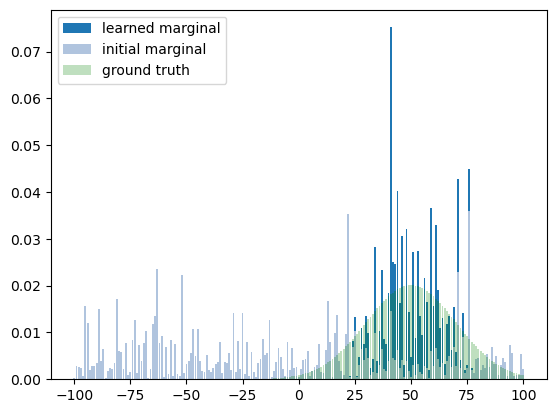

In [490]:
# plot learned distribution using ot.primal_cost for ot comparison
learned, theta_init = learn_marginal_logits(mu_true, X, ot_marginal_loss_primal)
learned_mu_true = jax.nn.softmax(learned)
mu_init = jax.nn.softmax(theta_init[0])
plt.bar(X, learned_mu_true, label="learned marginal")
plt.bar(X, mu_init, label="initial marginal", color="lightsteelblue")
plt.bar(X, mu_true, label="ground truth", color="green", alpha=0.25)
plt.legend()
plt.show()

In [415]:
# initialize a random array
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
theta = jax.random.normal(key=subkey, shape=X.shape)
X_reshaped = X.reshape(X.shape[0], 1).astype(float)

logit_loss(theta, mu_true, X_reshaped)
#learn_marginal_logits(mu_true)

#jax.grad(logit_loss)(theta, mu_true, X=X_reshaped)

#mu = gaussian_kernel(0, 1, X)
#X_reshaped = X.reshape(X.shape[0], 1).astype(float)
#jax.grad(ot_marginal_loss)(mu, mu_true, X_reshaped)
#jax.grad(loss)(jnp.array(0.1), mu_true, X)

Array(3285.7407, dtype=float32)

In [72]:
a = jnp.arange(4)
b = jnp.arange(5)
X, Y = jnp.meshgrid(a, b, indexing="ij")
XY = jnp.stack([X, Y], axis=-1).reshape((20, 2))
XY
#ot_marginal_loss

Array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [3, 4]], dtype=int32)